<a href="https://colab.research.google.com/github/sivarohith99/Grant_title_genration/blob/main/BART_base_grant_title_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers datasets rouge-score bert-score torch nltk
!pip install git+https://github.com/neulab/BARTScore.git


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.6 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=f5a5a6066f6208c28d7dc39effda774a798a04c854a3ad927eabe31335c67eb7
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's d

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = "title_abstract.xlsx"
data = pd.read_excel(file_path)

# Check dataset structure
print(data.head())  # Ensure columns like "abstract" and "title" exist

# Split the dataset
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)  # 70% training
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)  # 15% validation, 15% testing

# Save splits into DataFrames
train_data.to_csv("train.csv", index=False)
val_data.to_csv("val.csv", index=False)
test_data.to_csv("test.csv", index=False)


                                doi  \
0     10.1090/S0002-9939-06-08360-2   
1                 10.1021/JO200213X   
2  10.1111/J.1468-0262.2008.00849.X   
3         10.1017/S0074180900195506   
4          10.1109/TSP.2015.2449255   

                                               title  \
0  A note on uniformization of riemann surfaces b...   
1  With a little help from my friends: forty year...   
2                    Political Economy of Mechanisms   
3  WIYN Open Cluster Study: Tidal Interactions in...   
4  A Saddle Point Algorithm for Networked Online ...   

                                            abstract  
0  We clarify that the Ricci flow can be used to ...  
1  Over the past 40 years, much of the author's r...  
2  We study the optimal Mirrlees taxation problem...  
3  We present an ongoing study on tidal interacti...  
4  An algorithm to learn optimal actions in conve...  


In [5]:
from datasets import Dataset
from transformers import BartTokenizer

# Load datasets
train_dataset = Dataset.from_pandas(pd.read_csv("train.csv"))
val_dataset = Dataset.from_pandas(pd.read_csv("val.csv"))
test_dataset = Dataset.from_pandas(pd.read_csv("test.csv"))

# Initialize tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

# Preprocessing function
def preprocess_data(examples):
    inputs = tokenizer(
        examples['abstract'], max_length=512, truncation=True, padding="max_length", return_tensors="pt"
    )
    targets = tokenizer(
        examples['title'], max_length=128, truncation=True, padding="max_length", return_tensors="pt"
    )
    return {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'labels': targets['input_ids']
    }

# Apply preprocessing
tokenized_train = train_dataset.map(preprocess_data, batched=True, remove_columns=['abstract', 'title'])
tokenized_val = val_dataset.map(preprocess_data, batched=True, remove_columns=['abstract', 'title'])
tokenized_test = test_dataset.map(preprocess_data, batched=True, remove_columns=['abstract', 'title'])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

Map:   0%|          | 0/3481 [00:00<?, ? examples/s]

Map:   0%|          | 0/746 [00:00<?, ? examples/s]

Map:   0%|          | 0/747 [00:00<?, ? examples/s]

In [7]:
from transformers import BartForConditionalGeneration, Trainer, TrainingArguments

# Load model
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",        # Save the model at the end of each epoch
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir='./logs',
    load_best_model_at_end=True
)


# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer
)

# Train the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-7-eadfc2d5c82e>:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,No log,0.429585
2,1.030600,0.418229
3,0.378300,0.419497


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=1308, training_loss=0.6176640221831995, metrics={'train_runtime': 1120.2195, 'train_samples_per_second': 9.322, 'train_steps_per_second': 1.168, 'total_flos': 3183738916700160.0, 'train_loss': 0.6176640221831995, 'epoch': 3.0})

In [24]:
trainer.save_model('./fine_tuned_model')

In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer
from rouge_score import rouge_scorer
from bert_score import score as bert_score
import torch

# Load the fine-tuned model and tokenizer
model = BartForConditionalGeneration.from_pretrained('./fine_tuned_model')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

# Initialize ROUGE scorer
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Define evaluation function (now only uses test data)
def evaluate_model(model, tokenizer, test_data):
    results = []
    for example in test_data:
        # Tokenizing input abstract for generation
        input_ids = tokenizer.encode(example['abstract'], return_tensors='pt', truncation=True).to(model.device)

        # Generate text using the fine-tuned model
        generated_ids = model.generate(input_ids, max_length=128, num_beams=4, early_stopping=True)
        generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

        # Define reference (true output)
        reference_text = example['title']

        # Calculate ROUGE scores
        rouge_scores = rouge_scorer.score(reference_text, generated_text)

        # Calculate BERTScore
        bert_scores = bert_score([generated_text], [reference_text], lang='en')

        results.append({
            "reference": reference_text,
            "generated": generated_text,
            "rouge": {
                "rouge1": rouge_scores['rouge1'].fmeasure,
                "rouge2": rouge_scores['rouge2'].fmeasure,
                "rougeL": rouge_scores['rougeL'].fmeasure
            },
            "bert": bert_scores[2][0].item()
        })

    return results

# Assuming you have test data (replace `test_data` with your actual test set)
test_results = evaluate_model(model, tokenizer, test_data.to_dict('records'))

# Output results
for result in test_results:
    print(f"Reference: {result['reference']}\nGenerated: {result['generated']}")
    print(f"ROUGE Scores: {result['rouge']}")
    print(f"BERTScore: {result['bert']}")
    print("-" * 50)


In [28]:
from transformers import BartForConditionalGeneration, BartTokenizer
from rouge_score import rouge_scorer
from bert_score import score as bert_score
import torch
import pandas as pd

# Load the fine-tuned model and tokenizer
model = BartForConditionalGeneration.from_pretrained('./fine_tuned_model').to('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

# Initialize ROUGE scorer
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Read the test dataset
test_data = pd.read_csv("test.csv")

# Define batch size for evaluation
batch_size = 16

# Function to evaluate in batches
def evaluate_model(model, tokenizer, test_data, batch_size=16):
    results = []
    # Create batches
    for start in range(0, len(test_data), batch_size):
        batch = test_data.iloc[start:start + batch_size]

        # Tokenize the abstracts in the batch
        inputs = tokenizer(batch['abstract'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512).to(model.device)

        # Generate text for the batch
        generated_ids = model.generate(inputs['input_ids'], max_length=128, num_beams=4, early_stopping=True)
        generated_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

        # Calculate ROUGE and BERTScore for the batch
        for idx, example in batch.iterrows():
            reference_text = example['title']
            generated_text = generated_texts[idx - start]

            # ROUGE Scores
            rouge_scores = rouge_scorer.score(reference_text, generated_text)

            # BERTScore
            bert_scores = bert_score([generated_text], [reference_text], lang='en')

            results.append({
                "reference": reference_text,
                "generated": generated_text,
                "rouge": {
                    "rouge1": rouge_scores['rouge1'].fmeasure,
                    "rouge2": rouge_scores['rouge2'].fmeasure,
                    "rougeL": rouge_scores['rougeL'].fmeasure
                },
                "bert": bert_scores[2][0].item()
            })

    return results

# Evaluate the fine-tuned model on test data in batches
test_results = evaluate_model(model, tokenizer, test_data, batch_size=16)

# Output results
for result in test_results:
    print(f"Reference: {result['reference']}\nGenerated: {result['generated']}")
    print(f"ROUGE Scores: {result['rouge']}")
    print(f"BERTScore: {result['bert']}")
    print("-" * 50)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Reference: A Study on Biodiesel NOx Emission Control With the Reduced Chemical Kinetics Model
Generated: Effects of the start of injection timing and EGR Rate on the nitrogen oxide emissions of biodiesel-powered diesel engine
ROUGE Scores: {'rouge1': 0.24242424242424246, 'rouge2': 0.0, 'rougeL': 0.12121212121212123}
BERTScore: 0.8692658543586731
--------------------------------------------------
Reference: Cathodoluminescence Microanalysis of Irradiated Microcrystalline and Nanocrystalline Samarium Doped BaFCl
Generated: Cathodoluminescence microanalysis of BaFCl:Sm3+ nanoparticles.
ROUGE Scores: {'rouge1': 0.5, 'rouge2': 0.2857142857142857, 'rougeL': 0.5}
BERTScore: 0.893236517906189
--------------------------------------------------
Reference: Optoelectronic and all-optical multiple memory states in vanadium dioxide
Generated: Resistance and Transmittance of Vanadium dioxide in the Heterogeneous Transition
ROUGE Scores: {'rouge1': 0.4000000000000001, 'rouge2': 0.1111111111111111, 'ro

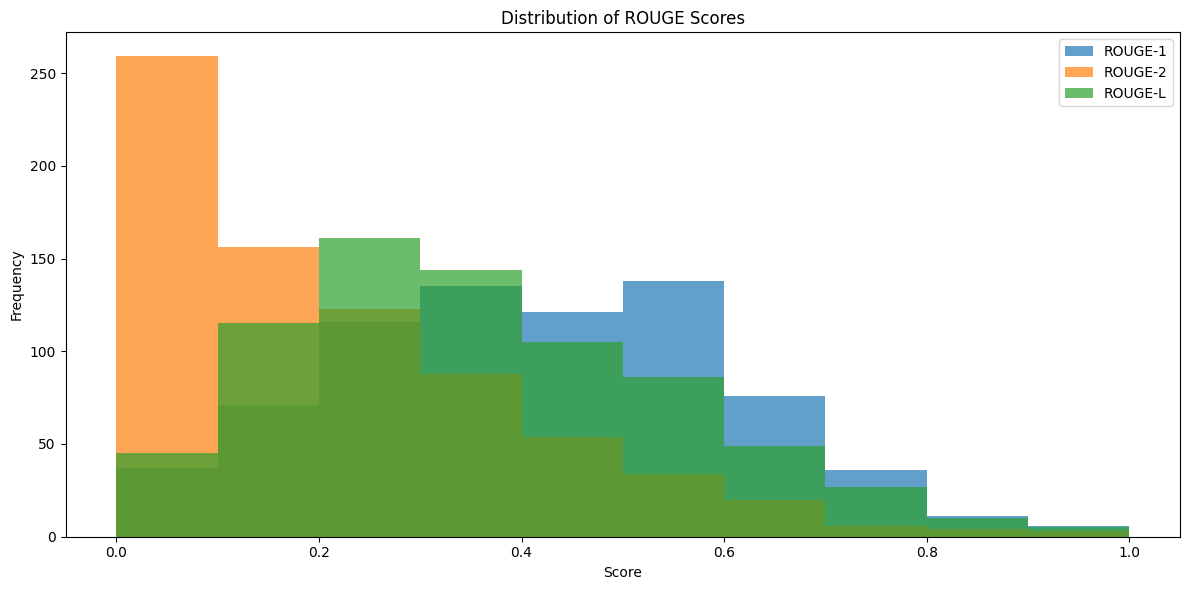

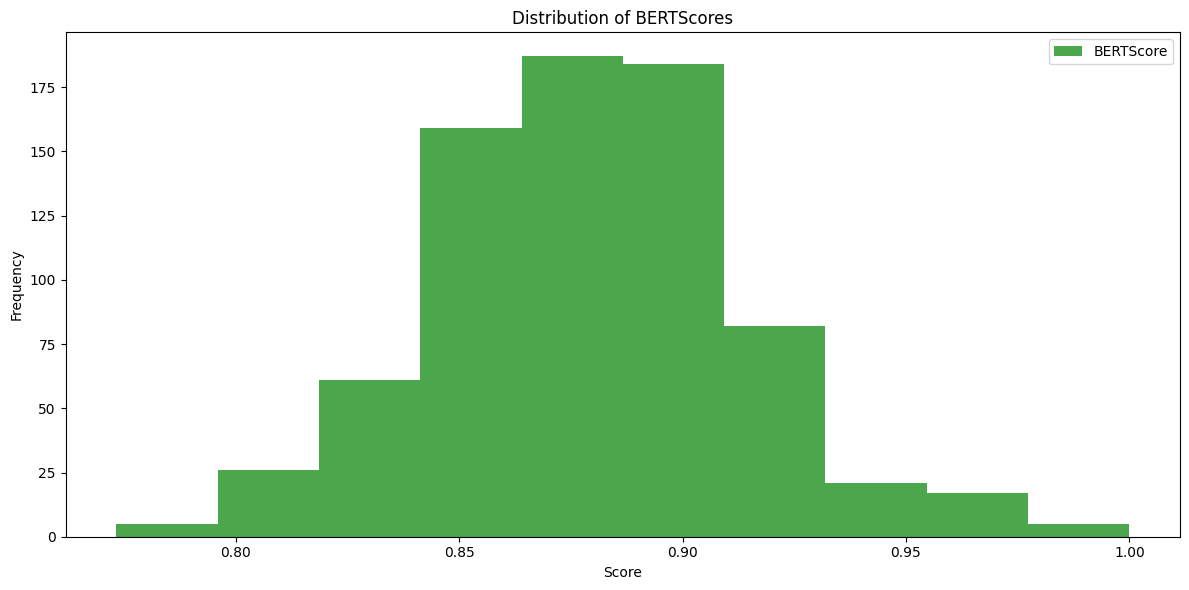

Average ROUGE-1: 0.41305159671438746
Average ROUGE-2: 0.2063649231474955
Average ROUGE-L: 0.35971299616454167
Average BERTScore: 0.8792136058590339


In [36]:
import matplotlib.pyplot as plt
import numpy as np
from bert_score import score as bert_score

# Extract ROUGE scores from test_results
rouge1_scores = [result['rouge']['rouge1'] for result in test_results]
rouge2_scores = [result['rouge']['rouge2'] for result in test_results]
rougeL_scores = [result['rouge']['rougeL'] for result in test_results]

# Extract BERTScore from test_results
bert_scores = [result['bert'] for result in test_results]

# Calculate average ROUGE and BERTScore
avg_rouge1 = np.mean(rouge1_scores)
avg_rouge2 = np.mean(rouge2_scores)
avg_rougeL = np.mean(rougeL_scores)
avg_bert_score = np.mean(bert_scores)

# Set fixed plot display
plt.ioff()  # Disable interactive mode if running in interactive environment (like Jupyter)

# Plotting ROUGE scores
plt.figure(figsize=(12, 6))
plt.hist(rouge1_scores, bins=10, alpha=0.7, label="ROUGE-1")
plt.hist(rouge2_scores, bins=10, alpha=0.7, label="ROUGE-2")
plt.hist(rougeL_scores, bins=10, alpha=0.7, label="ROUGE-L")
plt.title("Distribution of ROUGE Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()  # Adjust layout to avoid any overlaps
plt.show()

# Plotting BERTScore
plt.figure(figsize=(12, 6))
plt.hist(bert_scores, bins=10, alpha=0.7, label="BERTScore", color='green')
plt.title("Distribution of BERTScores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()  # Adjust layout to avoid any overlaps
plt.show()

# Print average scores
print(f"Average ROUGE-1: {avg_rouge1}")
print(f"Average ROUGE-2: {avg_rouge2}")
print(f"Average ROUGE-L: {avg_rougeL}")
print(f"Average BERTScore: {avg_bert_score}")

